<a href="https://colab.research.google.com/github/kgpark88/visionai/blob/main/day2/cnn_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG Net CNN 아키텍처 구현 - TensorFlow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard 
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
if gpus: 
    try: 
        for gpu in gpus: 
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU') 
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
    except RuntimeError as e: 
        print(e)

1 Physical GPUs, 1 Logical GPUs


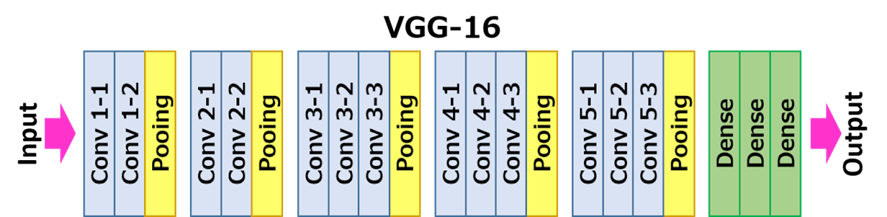

### VGG Net
- GlobalAveragePooling으로 Flatten적용 
- 참고 : https://gaussian37.github.io/dl-concept-global_average_pooling/

In [ ]:
input_tensor = Input(shape=(224, 224, 3))

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv1-1')(input_tensor)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv1-2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='Pooling1')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2-1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2-2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='Pooling2')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='Conv3-1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='Conv3-2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='Conv3-3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='Pooling3')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv4-1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv4-2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv4-3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='Pooling4')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv5-1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv5-2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv5-3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='Pooling5')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(units = 120, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(units=10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1-1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1-2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
Pooling1 (MaxPooling2D)      (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2-1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
Conv2-2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
Pooling2 (MaxPooling2D)      (None, 56, 56, 128)       0     

### conv_block() 함수  


In [ ]:
def conv_block(tensor_in, filters, kernel_size, repeats=2, pool_strides=(2, 2), block_id=1):
    x = tensor_in
    for i in range(repeats):
        name = 'Conv'+str(block_id)+'-'+str(i+1)
        x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', name=name)(x)
    x = MaxPooling2D((2, 2), strides=pool_strides, name='Pooling'+str(block_id))(x)
    return x

### conv_block() 함수로 VGG 16 Net 생성 


In [ ]:
def vggnet(in_shape=(224, 224,3), n_classes=10):
    input_tensor = Input(shape=in_shape, name='Input Tensor')
    x = conv_block(input_tensor, filters=64, kernel_size=(3, 3), repeats=2, pool_strides=(2, 2), block_id=1)
    x = conv_block(x, filters=128, kernel_size=(3, 3), repeats=2, pool_strides=(2, 2), block_id=2)
    x = conv_block(x, filters=256, kernel_size=(3, 3), repeats=3, pool_strides=(2, 2), block_id=3)
    x = conv_block(x, filters=512, kernel_size=(3, 3), repeats=3, pool_strides=(2, 2), block_id=4)
    x = conv_block(x, filters=512, kernel_size=(3, 3), repeats=3, pool_strides=(2, 2), block_id=5)
    
    # GlobalAveragePooling으로 Flatten적용. 
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(units = 120, activation = 'relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units = n_classes, activation = 'softmax')(x)

    model = Model(inputs=input_tensor, outputs=output, name='vgg_by_block')    
    return model

In [ ]:
model =  vggnet(in_shape=(224, 224, 3), n_classes=10)
model.summary()

Model: "vgg_by_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Tensor (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1-1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1-2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
Pooling1 (MaxPooling2D)      (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2-1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
Conv2-2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
Pooling2 (MaxPooling2D)      (None, 56, 56, 128)      

### 데이터셋 로드
- The CIFAR-10 dataset contains 60,000 colour images, each with dimensions 32x32px. 
- The content of the images within the dataset is sampled from 10 classes.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### 데이터셋 분리

In [ ]:
validation_images = train_images[:5000]
validation_labels = train_labels[:5000] 
train_images = train_images[5000:]
train_labels = train_labels[5000:]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

### 이미지 확인

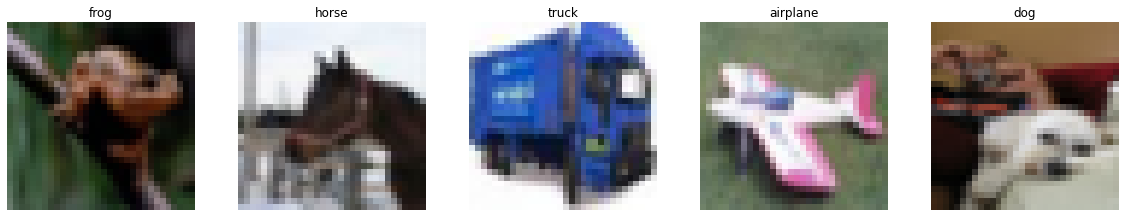

In [ ]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

### 데이터 전처리 함수

### CIFAR10 데이터 세트로 VGG16 모델 학습 및 성능 테스트

In [ ]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 224x224
    image = tf.image.resize(image, (224,224))
    return image, label

### 데이터셋 준비

In [ ]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


In [ ]:
buffer_size = 10000
batch_size = 64

train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size, drop_remainder=True))

### VGG 모델

In [ ]:
model = vggnet(in_shape=(224, 224, 3), n_classes=10)

In [ ]:
model.summary()

Model: "vgg_by_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Tensor (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1-1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1-2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
Pooling1 (MaxPooling2D)      (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2-1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
Conv2-2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
Pooling2 (MaxPooling2D)      (None, 56, 56, 128)      

### 모델 컴파일

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

### 모델 훈련

In [ ]:
epochs = 50

# validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
es = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
ts = TensorBoard('logs/vgg')

model.fit(train_ds,
          epochs=epochs,
          validation_data=validation_ds,
          callbacks=[rl, es, ts])

Epoch 1/50
101/703 [===>..........................] - ETA: 16:47 - loss: 2.2665 - accuracy: 0.1218

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/vgg